In [6]:
contributor = "Nada"

### Step 1: Import Libraries

In [4]:
import pandas as pd
import json
import numpy as np
import csv
from datetime import datetime
import os
# from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.ensemble import RandomForestRegressor
# import plotly.graph_objects as go
# from pandarallel import pandarallel
# import matplotlib.pyplot as plt
# pandarallel.initialize(progress_bar=True)
# import pytz

### Step 2: Load and Preprocess Data

In [5]:
# Directory and file name pattern
directory = 'Cleaning/trial_week/clean_data'
file_base = 'clean_2024-01-'


# Generate the list of file names
files_names = [f'{file_base}{i}.json' for i in range(28, 29)] # 32

# Generate the list of file directories
files = [os.path.join(directory, file_name) for file_name in files_names]

data = []

In [7]:
# Load data from each JSON file
for file_name in files:
    with open(file_name, 'r') as file:
        for line in file:
            data.append(json.loads(line))

# Create a DataFrame
df = pd.DataFrame(data)

# Step 1: Drop the 'time_diff' attribute if it exists
if 'time_diff' in df.columns:
    df.drop('time_diff', axis=1, inplace=True)

# # Step 2: Redefine the features after dropping 'time_diff'
# X = df_features.drop(columns=['time_diff'], errors='ignore')

# Calculate trip time in seconds
df['trip_time'] = df['time']

# Now, drop the 'time' column
df.drop(columns=['time'], inplace=True)

# Drop rows with missing values (if any)
df.dropna(inplace=True)

### Step 3: Prepare Features and Target

In [10]:
import folium
initial_lat = df['lats'][0][0]  # First latitude of the first row
initial_lon = df['lngs'][0][0]  # First longitude of the first row
m = folium.Map(location=[initial_lat, initial_lon], zoom_start=12)

In [11]:
total_coords = df['lats'].apply(len).sum()

print(f"Total number of coordinates in the DataFrame: {total_coords}")

Total number of coordinates in the DataFrame: 1386143


##### Listing all trips that share the same src and dst clusters

In [22]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
import numpy as np

# # Example DataFrame format
# df = pd.DataFrame({'lats': [[25.276987, 25.276998], [25.285557, 25.293304]], 
#                    'lngs': [[55.296249, 55.296259], [55.315227, 55.320907]]})

# Step 1: Flatten the coordinates for clustering
all_lats = [lat for sublist in df['lats'] for lat in sublist]
all_lngs = [lng for sublist in df['lngs'] for lng in sublist]
coords = np.array(list(zip(all_lats, all_lngs)))

# Perform clustering
num_clusters = 100  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coords)
cluster_labels = kmeans.labels_

# Create a mapping from coordinates to cluster labels
coord_to_cluster = dict(zip(map(tuple, coords), cluster_labels))

# Step 2: Determine clusters for initial and destination points
def get_cluster_id(lat, lon):
    return coord_to_cluster.get((lat, lon), None)

df['start_cluster'] = [get_cluster_id(row['lats'][0], row['lngs'][0]) for _, row in df.iterrows()]
df['end_cluster'] = [get_cluster_id(row['lats'][-1], row['lngs'][-1]) for _, row in df.iterrows()]

# Step 3: Categorize trips that share the same initial and destination clusters
trip_categories = df.groupby(['start_cluster', 'end_cluster']).apply(lambda x: x['trip_id'].tolist())

# Create a Folium map centered on the average lat and lon
average_lat = sum(all_lats) / len(all_lats)
average_lon = sum(all_lngs) / len(all_lngs)
m = folium.Map(location=[average_lat, average_lon], zoom_start=12)

# Add clustering to handle the large number of points
marker_cluster = MarkerCluster().add_to(m)

# Add each coordinate as a marker in the marker cluster
for idx, row in df.iterrows():
    folium.Marker([row['lats'][0], row['lngs'][0]]).add_to(marker_cluster)
    folium.Marker([row['lats'][-1], row['lngs'][-1]]).add_to(marker_cluster)
    # folium.PolyLine([
    #     [row['lats'][0], row['lngs'][0]],  # First point
    #     [row['lats'][-1], row['lngs'][-1]]  # Last point
    # ], color="blue", weight=2.5, opacity=1).add_to(m)

# Save the map to an HTML file
output_map = 'clustered_map_polyline.html'
m.save(output_map)

print(f"Map has been saved to {output_map}")

# Print categorized trips
print("Categorized trips:")
for (start_cluster, end_cluster), trips in trip_categories.items():
    print(f"From cluster {start_cluster} to cluster {end_cluster}: Trips {trips}")


/tmp/ipykernel_10421/1776748850.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trip_categories = df.groupby(['start_cluster', 'end_cluster']).apply(lambda x: x['trip_id'].tolist())


Map has been saved to clustered_map_polyline.html
Categorized trips:
From cluster 0 to cluster 0: Trips ['014b5f2a394191faf67fb4a3484f10b281afdc617413e492bb8250b407c8a5ef', '02b956d54997503a9e185001ec6c4db4c2a450ea8ba7695925e3d815af083e76', '05210f0dd965554043c7867a6bfe06ec89bf23b0d736dcefcc31cae23140fe70', '138290e1961dd5d6641a00378803caeb07cc3f629b6f64553d474c90379d4d28', '199453405322ebaab93584045c3e8a4d26d8c5be2903f4bf5588af9bdf8cfe72', '2e4a15ecc270f4a7ce0e3f95f85c6a13c33aaaff318607a1afc8a6e479e846fb', '33877ae694afd4b21d6c4b78562404b0ef3a96876bf91a95d602f7242e03a98c', '394d2985a1a0814e504af52b05fe1a3537440321b0258886378a84955cd09410', '3f5bb1b52039edabd08cc3ad8eeb5ea8f66b3709dd838c8111f27e6c6eaef14d', '407321b8dafe5c4beed34220272957c08d8b35590d523abad266f7c7ef65a038', '59c0194b33f65176d179385a2573ccbdfae6d55e24a320b9bf1ef4e947b06fc8', '639822087d4ec2d166bdb2d405b7a5231315763b110aec333d978febdf0e0203', '67492de00cfa4be4b0bea6f820f6ab8a7d97d07003337606fa768a98723278b2', '67ede83ca2

##### Trips that have the same src and dst with the same cluster (with Visualization)

In [31]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
import numpy as np

# Example DataFrame format
# df = pd.DataFrame({'lats': [[25.276987, 25.276998], [25.285557, 25.293304]], 
#                    'lngs': [[55.296249, 55.296259], [55.315227, 55.320907]],
#                    'trip_id': [1, 2]})

# Step 1: Flatten the coordinates for clustering
all_lats = [lat for sublist in df['lats'] for lat in sublist]
all_lngs = [lng for sublist in df['lngs'] for lng in sublist]
coords = np.array(list(zip(all_lats, all_lngs)))

# Perform clustering
num_clusters = 500  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coords)
cluster_labels = kmeans.labels_

# Create a mapping from coordinates to cluster labels
coord_to_cluster = dict(zip(map(tuple, coords), cluster_labels))

# Step 2: Determine clusters for initial and destination points
def get_cluster_id(lat, lon):
    return coord_to_cluster.get((lat, lon), None)

df['start_cluster'] = [get_cluster_id(row['lats'][0], row['lngs'][0]) for _, row in df.iterrows()]
df['end_cluster'] = [get_cluster_id(row['lats'][-1], row['lngs'][-1]) for _, row in df.iterrows()]

# Step 3: Check if a trip has the same starting and destination cluster
df['same_cluster'] = df['start_cluster'] == df['end_cluster']

# Create a Folium map centered on the average lat and lon
average_lat = sum(all_lats) / len(all_lats)
average_lon = sum(all_lngs) / len(all_lngs)
m = folium.Map(location=[average_lat, average_lon], zoom_start=12)

# Add clustering to handle the large number of points
marker_cluster = MarkerCluster().add_to(m)

# Add each coordinate as a marker in the marker cluster
for idx, row in df.iterrows():
    if row['same_cluster']:
        # Highlight trips with the same start and end cluster
        color = "red"
        weight = 3
    # else:
    #     # Default color for other trips
    #     color = "blue"
    #     weight = 2.5

        folium.Marker([row['lats'][0], row['lngs'][0]], icon=folium.Icon(color=color), tooltip=f'Trip ID: {row["trip_id"]}').add_to(marker_cluster)
        folium.Marker([row['lats'][-1], row['lngs'][-1]], icon=folium.Icon(color=color), tooltip=f'Trip ID: {row["trip_id"]}').add_to(marker_cluster)
        folium.PolyLine([
            [row['lats'][0], row['lngs'][0]],  # First point
            [row['lats'][-1], row['lngs'][-1]]  # Last point
        ], color=color, weight=weight, opacity=1).add_to(m)

# Save the map to an HTML file
output_map = 'clustered_map_polyline.html'
m.save(output_map)

print(f"Map has been saved to {output_map}")

# Print trips with the same starting and destination clusters
print("Trips with the same starting and destination clusters:")
same_cluster_trips = df[df['same_cluster']]
print(same_cluster_trips[['trip_id', 'start_cluster', 'end_cluster']])


Map has been saved to clustered_map_polyline.html
Trips with the same starting and destination clusters:
                                                trip_id  start_cluster  \
31    01ff05c850fb030d8174a48d70a7327747dd0177030bc5...            212   
54    02b956d54997503a9e185001ec6c4db4c2a450ea8ba769...            221   
72    037cb3f62285a7f581a220635225d383a08eeb50fe2c73...            212   
84    03c48c560d1f99a0a1cc7b61e145a616b287be4b47abf9...            352   
110   04f89f54bc53022b70027183bde55e1927fa38606c005d...            300   
...                                                 ...            ...   
5484  f07627136ef177015f13a6a76e3449a84aea7a4ce132c4...            156   
5636  f77af4e9259f1386836fb93e3b424e2639c81a15a8e8c9...            229   
5649  f82b6c7a45db4fd93e76d73881343d2aeeec3fefb87640...            212   
5701  fa0e4afe16418d65606d05d964a79f262449243c5bcf46...              0   
5703  fa1cb5bf8cba91ec7799c6f78a61d80f580f08a0f04046...              0   

      

###### Trips that have the same src and dst with the same cluster (with Visualization) Different visuals

In [37]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
import numpy as np
from shapely.geometry import MultiPoint
from shapely.ops import unary_union

# Example DataFrame format
# df = pd.DataFrame({'lats': [[25.276987, 25.276998], [25.285557, 25.293304]], 
#                    'lngs': [[55.296249, 55.296259], [55.315227, 55.320907]],
#                    'trip_id': [1, 2]})

# Step 1: Flatten the coordinates for clustering
all_lats = [lat for sublist in df['lats'] for lat in sublist]
all_lngs = [lng for sublist in df['lngs'] for lng in sublist]
coords = np.array(list(zip(all_lats, all_lngs)))

# Perform clustering
num_clusters = 500  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coords)
cluster_labels = kmeans.labels_

# Create a mapping from coordinates to cluster labels
coord_to_cluster = dict(zip(map(tuple, coords), cluster_labels))

# Step 2: Determine clusters for initial and destination points
def get_cluster_id(lat, lon):
    return coord_to_cluster.get((lat, lon), None)

df['start_cluster'] = [get_cluster_id(row['lats'][0], row['lngs'][0]) for _, row in df.iterrows()]
df['end_cluster'] = [get_cluster_id(row['lats'][-1], row['lngs'][-1]) for _, row in df.iterrows()]

# Step 3: Check if a trip has the same starting and destination cluster
df['same_cluster'] = df['start_cluster'] == df['end_cluster']

# Step 4: Prepare map
average_lat = sum(all_lats) / len(all_lats)
average_lon = sum(all_lngs) / len(all_lngs)
m = folium.Map(location=[average_lat, average_lon], zoom_start=12)

# Add clustering to handle the large number of points
marker_cluster = MarkerCluster().add_to(m)

# Step 5: Create and add polygons for each cluster
cluster_points = {}
for coord, label in zip(coords, cluster_labels):
    if label not in cluster_points:
        cluster_points[label] = []
    cluster_points[label].append(coord)

for label, points in cluster_points.items():
    if len(points) > 1:
        # Create a shapely polygon from the points
        multipoint = MultiPoint(points)
        convex_hull = multipoint.convex_hull
        coords = np.array(convex_hull.exterior.coords)
        # Convert to a list of lists for folium
        folium.Polygon(locations=coords.tolist(), color='blue', fill=True, fill_color='blue', fill_opacity=0.2).add_to(m)

# Add markers and polylines
for idx, row in df.iterrows():
    if row['same_cluster']:
        color = "red"
        weight = 3
    # else:
    #     color = "blue"
    #     weight = 2.5

        folium.Marker([row['lats'][0], row['lngs'][0]], icon=folium.Icon(color=color), tooltip=f'Trip ID: {row["trip_id"]}').add_to(marker_cluster)
        folium.Marker([row['lats'][-1], row['lngs'][-1]], icon=folium.Icon(color=color), tooltip=f'Trip ID: {row["trip_id"]}').add_to(marker_cluster)
        folium.PolyLine([
            [row['lats'][0], row['lngs'][0]],  # First point
            [row['lats'][-1], row['lngs'][-1]]  # Last point
        ], color=color, weight=weight, opacity=1).add_to(m)

# Save the map to an HTML file
output_map = 'clustered_map_polyline.html'
m.save(output_map)

print(f"Map has been saved to {output_map}")

# Print trips with the same starting and destination clusters
print("Trips with the same starting and destination clusters:")
same_cluster_trips = df[df['same_cluster']]
print(same_cluster_trips[['trip_id', 'start_cluster', 'end_cluster']])


Map has been saved to clustered_map_polyline.html
Trips with the same starting and destination clusters:
                                                trip_id  start_cluster  \
31    01ff05c850fb030d8174a48d70a7327747dd0177030bc5...            212   
54    02b956d54997503a9e185001ec6c4db4c2a450ea8ba769...            221   
72    037cb3f62285a7f581a220635225d383a08eeb50fe2c73...            212   
84    03c48c560d1f99a0a1cc7b61e145a616b287be4b47abf9...            352   
110   04f89f54bc53022b70027183bde55e1927fa38606c005d...            300   
...                                                 ...            ...   
5484  f07627136ef177015f13a6a76e3449a84aea7a4ce132c4...            156   
5636  f77af4e9259f1386836fb93e3b424e2639c81a15a8e8c9...            229   
5649  f82b6c7a45db4fd93e76d73881343d2aeeec3fefb87640...            212   
5701  fa0e4afe16418d65606d05d964a79f262449243c5bcf46...              0   
5703  fa1cb5bf8cba91ec7799c6f78a61d80f580f08a0f04046...              0   

      

##### Basic clustering without polylines (Dynamic)

In [19]:
import pandas as pd
import folium
from folium.plugins import HeatMap, MarkerCluster

# Assuming df['lats'] and df['lngs'] are lists of coordinates
# Example DataFrame format:
# df = pd.DataFrame({'lats': [[25.276987, 25.276998], [25.285557, 25.293304]], 
#                    'lngs': [[55.296249, 55.296259], [55.315227, 55.320907]]})

# Step 1: Calculate the average latitude and longitude from all points
all_lats = [lat for sublist in df['lats'] for lat in sublist]  # Flatten the list of lats
all_lngs = [lng for sublist in df['lngs'] for lng in sublist]  # Flatten the list of lngs

average_lat = sum(all_lats) / len(all_lats)  # Compute average latitude
average_lon = sum(all_lngs) / len(all_lngs)  # Compute average longitude

# Step 2: Create a folium map centered on the average lat and lon
m = folium.Map(location=[average_lat, average_lon], zoom_start=12)

# Step 3: Add clustering to handle the large number of points
marker_cluster = MarkerCluster().add_to(m)

# Step 4: Add each coordinate as a marker in the marker cluster
for idx, row in df.iterrows():
    # for lat, lon in zip(row['lats'], row['lngs']):
    folium.Marker([row['lats'][0], row['lngs'][0]]).add_to(marker_cluster)
    folium.Marker([row['lats'][-1], row['lngs'][-1]]).add_to(marker_cluster)
    # folium.PolyLine([
    #     [row['lats'][0], row['lngs'][0]],  # First point
    #     [row['lats'][-1], row['lngs'][-1]]  # Last point
    # ], color="blue", weight=2.5, opacity=1).add_to(m)

# Step 5: Save the map to an HTML file
output_map = 'clustered_map.html'
m.save(output_map)

print(f"Map has been saved to {output_map}")


Map has been saved to clustered_map_polyline.html


### Step 4: Split the Data

In [7]:
# Split the data
# X_train, X_test, y_train, y_test = train_test_split(df, df['trip_time'], test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df, df['trip_time'], test_size=0.25, random_state=None)

# Convert non-numeric columns to numeric or drop them
def handle_non_numeric_columns(df):
    non_numeric_cols = df.select_dtypes(include=['object']).columns
    for col in non_numeric_cols:
        # Check if the column contains lists
        if df[col].apply(lambda x: isinstance(x, list)).any():
            # Convert lists to strings or drop the column
            df[col] = df[col].apply(lambda x: str(x) if isinstance(x, list) else x)
        # Factorize the column
        df[col] = pd.factorize(df[col])[0]
    return df

X_train = handle_non_numeric_columns(X_train)
X_test = handle_non_numeric_columns(X_test)



# Convert non-numeric columns to numeric or drop them
# non_numeric_cols = X_train.select_dtypes(include=['object']).columns
# X_train[non_numeric_cols] = X_train[non_numeric_cols].apply(lambda col: pd.factorize(col)[0])
# X_test[non_numeric_cols] = X_test[non_numeric_cols].apply(lambda col: pd.factorize(col)[0])

# Ensure all features are numeric
assert X_train.select_dtypes(include=['object']).empty, "There are still non-numeric columns in X_train"
assert X_test.select_dtypes(include=['object']).empty, "There are still non-numeric columns in X_test"

# Drop 'trip_time' from the training data
X_train_features = X_train.drop(columns=['trip_time'])
X_test_features = X_test.drop(columns=['trip_time'])

In [8]:
# print(X_train_features.columns)
# print(X_test_features.columns)
# print(X_train.columns)
# print(X_test.columns)
# print(y_train)

### Step 5: Hyperparameter Tuning and Model Training

##### * Only one parameter

In [ ]:
# Recommended initial hyperparameter values
n_estimators = 800
max_depth = 10  # Let the tree grow until all leaves are pure or until they contain less than min_samples_split samples
min_samples_split = 2
min_samples_leaf = 4  # The minimum number of samples required to be at a leaf node
# max_leaf_nodes = None  # Let the trees grow until all leaves are pure or until they contain less than min_samples_split samples
random_state = 42  # Ensures reproducibility
# criterion = 'squared_error'  # Default criterion for regression tasks
max_features = None  # Consider sqrt of the number of features for each split
bootstrap = True # Bootstrap samples by default

# {'n_estimators': 800,
#  'min_samples_split': 2,
#  'min_samples_leaf': 4,
#  'max_features': None,
#  'max_depth': 10,
#  'bootstrap': True}

# Initialize and train the model with the recommended values
model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    # max_leaf_nodes=max_leaf_nodes,
    random_state=random_state,
    # criterion=criterion,
    max_features=max_features,
    bootstrap = bootstrap
)

# # Drop 'trip_time' from the training data
# X_train_features = X_train.drop(columns=['trip_time'])
# X_test_features = X_test.drop(columns=['trip_time'])


model.fit(X_train.drop(columns=['trip_time']), y_train)

RandomForestRegressor(max_depth=10, max_features=None, min_samples_leaf=4,
                      n_estimators=800, random_state=42)

#### Evaluate the model using RMSE

In [ ]:
# Evaluate the model using RMSE
y_pred = model.predict(X_test_features)
mse = mean_squared_error(y_test, y_pred, squared=False)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 22.804526908034514


C:\Users\nadab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Feature Importance Analysis

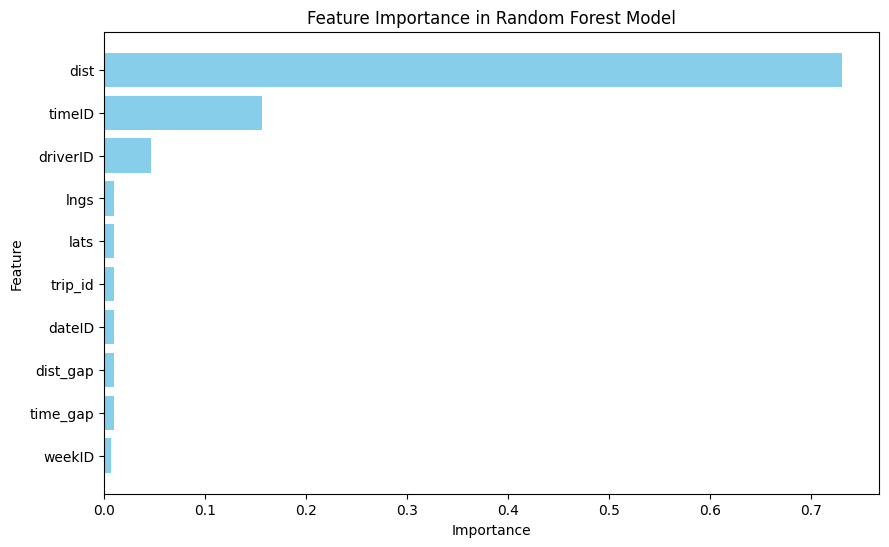

,Feature,Importance
2,dist,0.730625
6,timeID,0.156357
4,driverID,0.046938
8,lngs,0.009847
3,lats,0.009845
0,trip_id,0.009828
7,dateID,0.009808
9,dist_gap,0.009763
1,time_gap,0.009714
5,weekID,0.007276


In [ ]:
feature_importances = model.feature_importances_

# Step 6: Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_train_features.columns,
    'Importance': feature_importances
})

# Step 7: Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 8: Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

# Output the importance DataFrame for review
importance_df

### Step 6: Evaluate the Model with Learning Curves

In [ ]:
# Get current timestamp in Cairo time
cairo_tz = pytz.timezone('Africa/Cairo')
timestamp = datetime.now(cairo_tz).strftime('%Y-%m-%dT%H:%M:%S')

# Generate a unique label based on the timestamp
label = 'Model_Run_' + timestamp.replace(':', '').replace('-', '').split('.')[0]
# label = 'Model_Run_' + datetime.now().strftime("%Y%m%d_%H%M%S")

print(timestamp)
print(label)

2024-08-16T20:59:47
Model_Run_20240816T205947


In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_train.drop(columns=['trip_time']), y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5, scoring='neg_root_mean_squared_error')


fig = go.Figure()
fig.add_trace(go.Scatter(x=train_sizes, y=-np.mean(train_scores, axis=1), name='Training error'))
fig.add_trace(go.Scatter(x=train_sizes, y=-np.mean(valid_scores, axis=1), name='Validation error'))
fig.update_layout(
    title='Learning Curve: ' + label,
    xaxis_title='Number of Training Examples',
    yaxis_title='Root Mean Squared Error (RMSE)',
    legend_title='Error Type'
)
fig.show()

# Specify the directory and file name
output_directory = 'Careem_RFR_Figures/'  # Replace with your directory path
if not os.path.exists(output_directory):
    os.makedirs(output_directory)  # Create the directory if it doesn't exist
output_file = os.path.join(output_directory, f'learning_curve_v2.1_{label}.png')

# Save the figure
fig.write_image(output_file)

### Step 7: Make Predictions and Calculate Errors

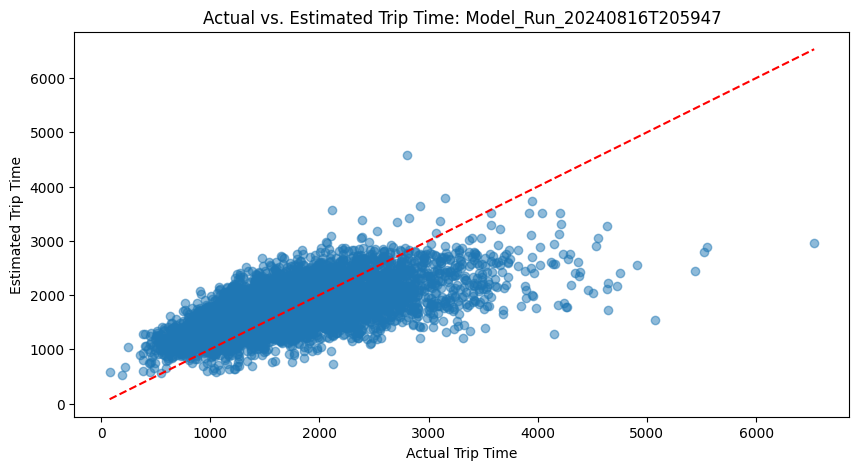

Mean Absolute Error (MAE): 390.49572726804627
R^2 Score: 0.4040463724914317


In [ ]:
def estimations(test_data, model, feature_names):
    features_data = test_data[feature_names]
    test_data['trip_time_estimate'] = model.predict(features_data)
    test_data['error'] = test_data['trip_time'] - test_data['trip_time_estimate']
    test_data = test_data.query("error < 3600")
    return test_data

# Get the feature names used during training
feature_names = X_train.drop(columns=['trip_time']).columns.tolist()

def plot_graphs(plot_df):
    plt.figure(figsize=(10, 5))
    plt.scatter(plot_df['trip_time'], plot_df['trip_time_estimate'], alpha=0.5)
    plt.plot([plot_df['trip_time'].min(), plot_df['trip_time'].max()], 
             [plot_df['trip_time'].min(), plot_df['trip_time'].max()], 'r--')
    plt.xlabel('Actual Trip Time')
    plt.ylabel('Estimated Trip Time')
    plt.title('Actual vs. Estimated Trip Time: ' + label)

    # Save the figure
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)  # Create the directory if it doesn't exist
    output_file = os.path.join(output_directory, f'actual_vs_estimated_v2.1_{label}.png')
    plt.savefig(output_file)
    plt.show()
    plt.close()

def get_metrics(plot_df):
    mae = mean_absolute_error(plot_df['trip_time'], plot_df['trip_time_estimate'])
    r2 = r2_score(plot_df['trip_time'], plot_df['trip_time_estimate'])
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R^2 Score: {r2}')
    return mae, r2

# Assuming plot_df is defined from the previous estimations step
plot_df = estimations(X_test, model, feature_names)
plot_graphs(plot_df)
mae, r2 = get_metrics(plot_df)

### Step 8: Log the results

In [ ]:
# Define the log file path
log_file_path = 'model_training_results_v2.1_log_.csv'

# Create a log file with headers if it doesn't exist
if not os.path.exists(log_file_path):
    with open(log_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Timestamp', 'Label', 'n_estimators', 'max_depth', 'min_samples_leaf', 'max_leaf_nodes', 'random_state', 'criterion', 'max_features', 'RMSE', 'MAE', 'R2_Score', 'Input_Data_Files', 'Contributor'])

def log_model_training(n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files):
    # Log details into CSV file
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([timestamp, label, n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files, contributor])


# Example usage
RMSE = rmse
MAE = mae
R2_Score = r2
# Convert list of files to a comma-separated string
input_data_files = ', '.join(files_names)
max_leaf_nodes = "Default"
criterion = "Default"
# input_data_files = 'clean_2024-01-25.json, clean_2024-01-26.json, clean_2024-01-27.json, clean_2024-01-28.json, clean_2024-01-29.json'

log_model_training(n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files)


In [ ]:
from sklearn import tree
tree.plot_tree(model.estimators_[0])

[Text(0.5223511464497042, 0.9545454545454546, 'x[2] <= 7.22\nsquared_error = 475296.511\nsamples = 11772\nvalue = 1745.377'),
 Text(0.25737333579881655, 0.8636363636363636, 'x[2] <= 4.052\nsquared_error = 284669.619\nsamples = 6619\nvalue = 1443.2'),
 Text(0.3898622411242604, 0.9090909090909092, 'True  '),
 Text(0.11281897189349112, 0.7727272727272727, 'x[2] <= 2.21\nsquared_error = 222138.411\nsamples = 2863\nvalue = 1216.339'),
 Text(0.04571930473372781, 0.6818181818181818, 'x[2] <= 0.887\nsquared_error = 199776.172\nsamples = 912\nvalue = 1048.645'),
 Text(0.011926775147928994, 0.5909090909090909, 'x[4] <= 119.0\nsquared_error = 154802.722\nsamples = 125\nvalue = 797.264'),
 Text(0.004807692307692308, 0.5, 'x[5] <= 1.5\nsquared_error = 57997.652\nsamples = 11\nvalue = 526.812'),
 Text(0.0033284023668639054, 0.4090909090909091, 'squared_error = 27656.543\nsamples = 6\nvalue = 370.111'),
 Text(0.00628698224852071, 0.4090909090909091, 'squared_error = 24845.061\nsamples = 5\nvalue = 72

Error in callback <function _draw_all_if_interactive at 0x00000261B4E6B7E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 